In [3]:
!python -V

Python 3.9.25


In [4]:
import pandas as pd
import numpy as np

In [5]:
import pickle

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error

In [17]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/mlops-NYtaxi-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1763377572298, experiment_id='1', last_update_time=1763377572298, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [9]:
def read_datafram(filename):
    df = pd.read_parquet(filename)
    
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60 )
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    categorical = ["PULocationID" , "DOLocationID"]
    
    df[categorical] = df[categorical].astype(str)
    return df

In [20]:
df_train = read_datafram("./data/green_tripdata_2022-01.parquet")
df_val = read_datafram("./data/green_tripdata_2022-02.parquet")

/tmp/ipykernel_46396/3394121782.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train.duration, label = "train_duration")
/tmp/ipykernel_46396/3394121782.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_val.duration, label = "val_duration")


<Axes: xlabel='duration', ylabel='Density'>

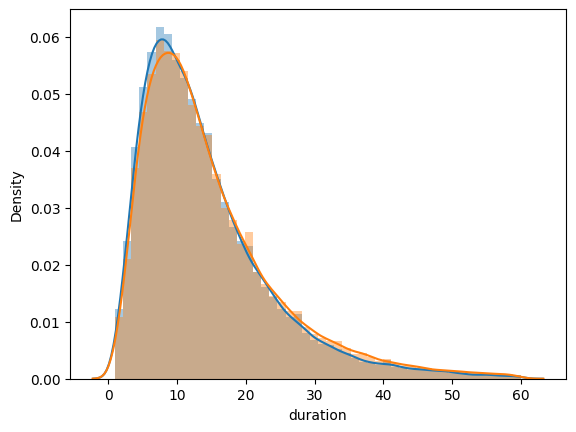

In [21]:
sns.distplot(df_train.duration, label = "train_duration")
sns.distplot(df_val.duration, label = "val_duration")

In [22]:
df_train["PU_DO"] = df_train["PULocationID"] + "_" + df_train["DOLocationID"]
df_val["PU_DO"] = df_val["PULocationID"] + "_" + df_val["DOLocationID"]

In [23]:
categorical = ["PU_DO"]#"PULocationID" , "DOLocationID"]
numerical = ["trip_distance"]

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient = "records")
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient = "records")
X_val= dv.transform(val_dicts)

In [24]:
target = "duration"

y_train = df_train[target].values
y_val = df_val[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)


y_pred = lr.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

np.float64(6.901396794753251)

In [15]:
with open("models/lin_reg.bin" , "wb") as f_out:
    pickle.dump((dv, lr), f_out)

FileNotFoundError: [Errno 2] No such file or directory: 'models/lin_reg.bin'

In [20]:
with mlflow.start_run():

    mlflow.set_tag("developer", "huang")

    mlflow.log_param("train-data-path", "./data/green_tripdata_2022-01.parquet")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2022-02.parquet")

    alpha = 0.01
    mlflow.log_param("alpha", alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mlflow.log_metric("rmse", rmse)

In [25]:
import xgboost as xgb

In [26]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [27]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [28]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [16]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

NameError: name 'scope' is not defined

In [29]:
params = {
    'learning_rate': 0.24089619310551078,
    'max_depth': 74,
    'min_child_weight': 0.9487921047627148,
    'objective': 'reg:linear',
    'reg_alpha': 0.02073356962608289,
    'reg_lambda': 0.06289929251092163,
    'seed': 42
}

mlflow.xgboost.autolog()

booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, 'validation')],
    early_stopping_rounds=50
    )

2025/11/17 12:19:01 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '836d746498144aedbc8bb7799467887b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:19:04] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:8.62205
[1]	validation-rmse:7.71409
[2]	validation-rmse:7.11969
[3]	validation-rmse:6.72560
[4]	validation-rmse:6.48660
[5]	validation-rmse:6.32926
[6]	validation-rmse:6.22173
[7]	validation-rmse:6.15853
[8]	validation-rmse:6.10216
[9]	validation-rmse:6.07456
[10]	validation-rmse:6.05353
[11]	validation-rmse:6.03191
[12]	validation-rmse:6.02088
[13]	validation-rmse:6.01202
[14]	validation-rmse:6.00600
[15]	validation-rmse:6.00050
[16]	validation-rmse:5.99755
[17]	validation-rmse:5.99330
[18]	validation-rmse:5.98992
[19]	validation-rmse:5.98791
[20]	validation-rmse:5.98236
[21]	validation-rmse:5.98128
[22]	validation-rmse:5.98132
[23]	validation-rmse:5.97912
[24]	validation-rmse:5.97625
[25]	validation-rmse:5.97321
[26]	validation-rmse:5.97256
[27]	validation-rmse:5.97134
[28]	validation-rmse:5.97076
[29]	validation-rmse:5.96895
[30]	validation-rmse:5.96808
[31]	validation-rmse:5.96792
[32]	validation-rmse:5.96787
[33]	validation-rmse:5.96760
[34]	validation-rmse:5.9

2025/11/17 12:19:50 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2025/11/17 12:19:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/17 12:19:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:19:50] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/11/17 12:19:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
